In [1]:
import xarray as xr
import numpy as np
import sys
from glob import glob
import gc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/home/vmaithel')

g = 9.8 #[m s^-2]
L = 2.26e6 #[J/kg]
cp = 1005 #[J/kg-K]
R_e = 6.378e6 #[m]
pi = 22/7
"""
local scripts, if loading from a different directory include that with a '.' between
directory name and script name
"""
from tropical_PODs.PODs.POD_utils import limit_files_to_select_years
from tropical_PODs.PODs.POD_utils import calculate_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.plotting_utils import plot_one_variable_binned_ivar
from tropical_PODs.PODs.plotting_utils import plot_two_variables_binned_ivar
from tropical_PODs.PODs.POD_utils import numerical_plume_model
from tropical_PODs.PODs.POD_utils import calculate_CAPE

In [2]:
def load_in_data(input_file, xarray_name, start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level):
    
    paths = glob(input_file)
    year_limited_paths = limit_files_to_select_years(paths,range(start_year,end_year+1))
    dataset = xr.open_mfdataset(year_limited_paths, combine="by_coords")
    dataset = dataset.sortby('lat', ascending=True)

    if 'level' in dataset.dims:
        data_var = dataset[xarray_name].sel(time = slice(str(start_year)+'-01-01', str(end_year)+'-12-31'), lat = slice(lat_lbound,lat_ubound), level = slice(upper_level, lower_level))
    else: 
        data_var = dataset[xarray_name].sel(time = slice(str(start_year)+'-01-01', str(end_year)+'-12-31'), lat = slice(lat_lbound,lat_ubound))

    data_var.load()

    return dataset, data_var

In [3]:
# Years to analyze
start_year = (2011)
end_year = (2011)

lat_lbound = -10 
lat_ubound = 10

upper_level = 100
lower_level = 1000

################
###.  VIJIT MSE budget calculations  ###
################

input_dir = '/home/vmaithel/MSE_budgets/2p5_vijit/no_seasonality/'

input_file_MSE_tend = input_dir+'MSE_tend_ns.*.nc'  
input_file_col_MSE = input_dir+'col_MSE_ns.*.nc' 
input_file_col_VADV = input_dir+'col_VADV_ns.*.nc' 
input_file_col_HADV = input_dir+'col_HADV_ns.*.nc' 
input_file_col_HADV_zonal = input_dir+'col_HADV_zonal_ns.*.nc'  
input_file_col_HADV_meridional = input_dir+'col_HADV_meridional_ns.*.nc' 
input_file_SF = input_dir+'SF_ns.*.nc'
input_file_RadF_net = input_dir+'RadF_net_ns.*.nc'

dataset_col_MSE, col_MSE = load_in_data(input_file_col_MSE,'col_MSE_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_VADV, col_VADV = load_in_data(input_file_col_VADV,'col_VADV_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_HADV, col_HADV = load_in_data(input_file_col_HADV,'col_HADV_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_HADV_zonal, col_HADV_zonal = load_in_data(input_file_col_HADV_zonal,'col_HADV_zonal_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_HADV_meridional, col_HADV_meridional = load_in_data(input_file_col_HADV_meridional,'col_HADV_meridional_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_MSE_tend, MSE_tend = load_in_data(input_file_MSE_tend,'MSE_tend_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_SF, SF = load_in_data(input_file_SF,'SF_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_RadF_net, RadF_net = load_in_data(input_file_RadF_net,'RadF_net_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)


In [4]:
odir_datasets = '/home/vmaithel/MSE_budgets/binned_data/'

# Output directory for plots
odir_plots = '/home/vmaithel/plots/'

In [5]:
##### Load in CAPE and precipitation data

input_dir_CAPE = '/Projects/era5_regrid/2p5_vijit/'

input_file_CAPE = input_dir_CAPE + 'CAPE_variables_*.nc'

dataset_CAPE, CAPE_DIB_1000_to_600 = load_in_data(input_file_CAPE,'CAPE_DIB_1000_to_600', start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_CAPE, CAPE_NOMIX_1000_to_600 = load_in_data(input_file_CAPE,'CAPE_NOMIX_1000_to_600', start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)

input_file_precip = '/Projects/era5_regrid/IMERG/3B-DAY.MS.MRG.3IMERG.V06.*' # IMERG Precipitation'
dataset_precip, precipitation_rate = load_in_data(input_file_precip, 'precipAvg', start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
precipitation_rate = precipitation_rate*24 #convert from mm/hr to mm/day
precipitation_rate = precipitation_rate.resample(time='1D').mean('time')

precipitation_rate['time'] = precipitation_rate.indexes['time'].to_datetimeindex() # IMERG time was saved as CFtime, and we need to convert to datetime for xarray

print(precipitation_rate)

<xarray.DataArray 'precipAvg' (time: 365, lat: 9, lon: 144)>
array([[[1.68504443e-03, 7.51780243e-04, 1.90737619e-04, ...,
         6.16566206e-02, 4.78880055e-02, 9.65026910e-04],
        [0.00000000e+00, 1.68443877e-05, 9.97800955e-02, ...,
         7.06779127e-03, 0.00000000e+00, 0.00000000e+00],
        [1.50765658e-01, 3.40161580e-01, 1.18459803e+01, ...,
         1.35016613e-04, 1.73191307e-04, 5.73116934e-03],
        ...,
        [5.91244757e-02, 7.72950217e-03, 1.03282438e-01, ...,
         1.40758528e-01, 2.23610406e-01, 3.06983825e-01],
        [7.09181039e-02, 6.29739077e-03, 1.27563698e-02, ...,
         2.00341977e-01, 1.55387685e-01, 8.97186853e-02],
        [4.56669339e-03, 4.62162825e-04, 1.47999247e-03, ...,
         8.53728583e-02, 3.26722271e-02, 1.07643250e-02]],

       [[3.21061038e-03, 0.00000000e+00, 0.00000000e+00, ...,
         2.00063986e-02, 1.14546333e-02, 2.83765189e-03],
        [0.00000000e+00, 0.00000000e+00, 4.09727585e-02, ...,
         1.16539168e-0

/tmp/ipykernel_3206593/3053744313.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  precipitation_rate['time'] = precipitation_rate.indexes['time'].to_datetimeindex() # IMERG time was saved as CFtime, and we need to convert to datetime for xarray


In [6]:
#### Applying land mask

# Land
ifile_land_frac = '/Projects/era5_regrid/2p5_vijit/ERAi_landfrac_2p5.nc' # ERAi Land Fraction

dataset_land = xr.open_dataset(ifile_land_frac)
landfrac = dataset_land['landfrac']
landfrac.load()
landfrac = landfrac.sortby('lat', ascending=True) # Re-order lat to match code for other datasets

landfrac = landfrac.sel(lat = slice(lat_lbound, lat_ubound)) 

# Create ocean mask #

is_valid_ocean_mask = (landfrac < 0.1)

precipitation_rate = precipitation_rate.where(is_valid_ocean_mask, other = np.nan)

CAPE_DIB_1000_to_600 = CAPE_DIB_1000_to_600.where(is_valid_ocean_mask, other = np.nan)

CAPE_NOMIX_1000_to_600 = CAPE_NOMIX_1000_to_600.where(is_valid_ocean_mask, other = np.nan)

#col_VADV = col_VADV.where(is_valid_ocean_mask, other = np.nan)

#col_HADV = col_HADV.where(is_valid_ocean_mask, other = np.nan)

#MSE_tend = MSE_tend.where(is_valid_ocean_mask, other = np.nan)

#col_HADV_zonal = col_HADV_zonal.where(is_valid_ocean_mask, other = np.nan)

#col_HADV_meridional = col_HADV_meridional.where(is_valid_ocean_mask, other = np.nan)

#SF = SF.where(is_valid_ocean_mask, other = np.nan)

#RadF_net = RadF_net.where(is_valid_ocean_mask, other = np.nan)


In [7]:
########################################################################
###  Calculate CAPE_DIB_1000_to_600 + Log Precipitation Composites  ####
########################################################################

print('Starting CAPE_DIB_1000_to_600 + Log Precipitation Composites')

for year in range(start_year, end_year+1):

    ### Define binning parameters ###

    log_space = np.logspace(-4,3,num=29)
        
    BV1 = CAPE_DIB_1000_to_600.sel(time = str(year))
        
    BV1_name_str = 'CAPE_DIB_1000_to_600'
        
    BV1_units_str = '[J Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(-1500, 500, 25) # CAPE_DIB_1000_to_600

    upper_BV1_bin_limit_vector = np.arange(-1500 + 25, 500 + 25, 25) # CAPE_DIB_1000_to_600
        
    BV2 = precipitation_rate.sel(time = str(year))
        
    BV2_name_str = 'precipitation_rate'
        
    BV2_units_str = '[mm day^-1]'

    lower_BV2_bin_limit_vector = log_space[0 : -1] # Precipitation rate

    upper_BV2_bin_limit_vector = log_space[1 :] # Precipitation rate
        
    log_bins_boolean = True

    fname_datasets = odir_datasets

    #Data to be binned

    ivar = MSE_tend.sel(time = str(year))

    ivar_name_str = 'col_MSE_tendency'

    ivar_units_str = '[W m^-2]'
        
    ###   Precipitation Terms   ###

    calculate_two_variable_binned_coevolution_composites(BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)


Starting CAPE_DIB_1000_to_600 + Log Precipitation Composites
Calculating Differences
Binning and Compositing
Calculating Differences
Binning and Compositing


In [28]:
print(np.isnan(BV1.sel(time = str(year))))

<xarray.DataArray 'CAPE_DIB_1000_to_600' (time: 365, lat: 9, lon: 144)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [Fals

### Driver for plotting

In [9]:
# Define colormap # 

colors = [(10, 50, 120), (15, 75, 165), (30, 110, 200), (60, 160, 240), (80, 180, 250), (130, 210, 255), (160, 240, 255), (200, 250, 255), (230, 255, 255), (230, 230, 230), (230, 230, 230), (255, 250, 220), (255, 232, 120), (255, 192, 60), (255, 160, 0), (255, 96, 0), (255, 50, 0), (225, 20, 0), (192, 0, 0), (165, 0, 0)]
for list_index in range(len(colors)):
    colors[list_index] = tuple(tuple_element/255. for tuple_element in colors[list_index])
        
n_bin = 200
cmap_name = 'colors'
colormap_colors = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

### Define plotting parameters ###

min_number_of_obs = 200

years_to_plot_list = list(range(2011,2012))

print(years_to_plot_list)

[2011]


### Plotting - 

In [18]:
CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_col_MSE_tendency_composite_*'), years_to_plot_list))

In [20]:
print(CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_mean_ivar'].values)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


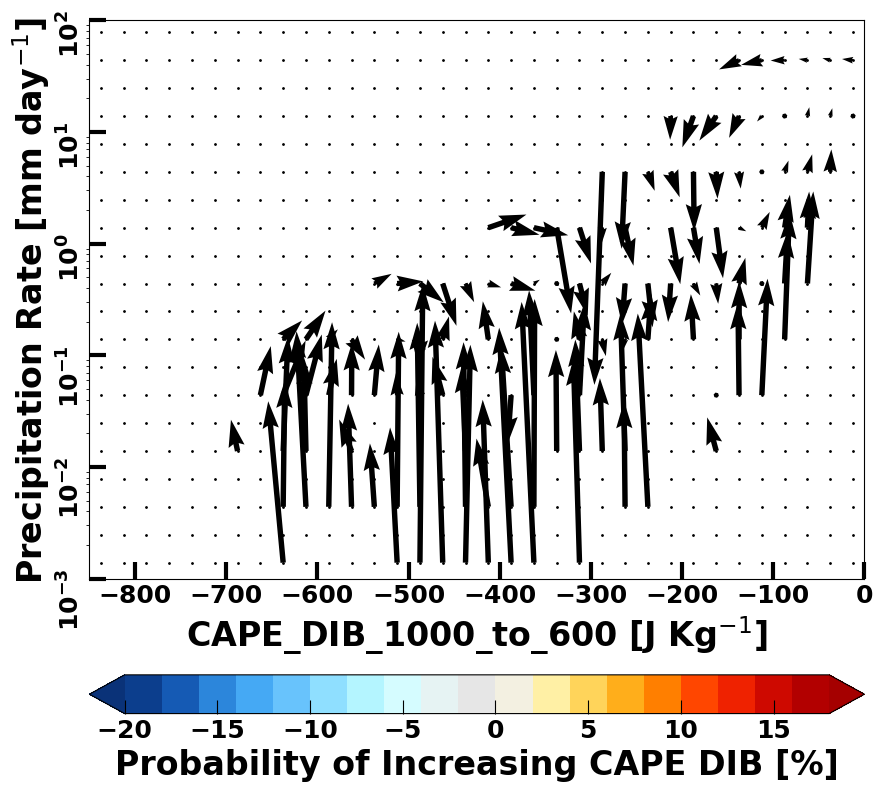

In [13]:
two_variable_binned_coevolution_composites = CAPE_DIB_1000_to_600_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (-850, 0)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CAPE_DIB_1000_to_600 [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_mean_ivar'] 
color_shading_var_number_of_samples = CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(-20, 20, 2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-20, 20, 5)
colorbar_label_string = 'Probability of Increasing CAPE DIB [%]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CAPE_DIB_1000_to_600_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)
